In [85]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import os 
import sys
sys.path.append('./Codebase/ann')
from Featurizer import featurizer
from TargetNormalize import target_bin

# 1. Fingerprints Calculation

In [86]:
df_0 = pd.read_csv('./Data/QSAR/Data_qsar.csv', index_col=0)

In [87]:
feature= featurizer(data=df_0, ID_col='ID', smiles_col='Smiles', type_fp = 'secfp', active_col = 'pIC50')
df=feature.fit()
df.head()

,ID,pIC50,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,10.193820,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,8.197705,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,7.980178,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,9.225483,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,9.349692,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Target normalization

In [88]:
df = target_bin(data = df, thresh = 10, Y_name = "pIC50")
df.head(5)

,ID,pIC50,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3. Data preparation

In [6]:
from sklearn.model_selection import train_test_split
X = df.drop(['ID','pIC50'],axis = 1)
y = df["pIC50"]
#Split Data train, Data_test, Data_validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                                random_state =42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1,
                                                                random_state =42, stratify=y_train)

#setting device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# change numpy to tensor gpu
X_train = torch.tensor(X_train.values , device=device).float()
X_val = torch.tensor(X_val.values , device=device).float()
X_test = torch.tensor(X_test.values, device=device).float()

y_train = torch.tensor(y_train.values , device=device).float()
y_val = torch.tensor(y_val.values, device=device).float()
y_test = torch.tensor(y_test.values, device=device).float()

# convert into dataloader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=64,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=64,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64,
                                          shuffle=False)

cuda:0


In [89]:
from sklearn.model_selection import train_test_split
X = df.drop(['ID','pIC50'],axis = 1)
y = df["pIC50"]
#Split Data train, Data_test, Data_validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                                random_state =42, stratify=y)


#setting device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# change numpy to tensor gpu
X_train = torch.tensor(X_train.values , device=device).float()

X_test = torch.tensor(X_test.values, device=device).float()

y_train = torch.tensor(y_train.values , device=device).float()

y_test = torch.tensor(y_test.values, device=device).float()

# convert into dataloader
train_dataset = TensorDataset(X_train, y_train)

test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=32,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=False)

cuda:0


# 4. Model

In [8]:
from ModelArchitecture import Net
from annpipeline import model_pipeline

from sklearn.metrics import f1_score, average_precision_score, classification_report

Epoch: 5/170..  Training Loss: 0.542..  validation Loss: 0.504..  validation f1_score: 0.732..  validation average precision: 0.824.. 
Epoch: 10/170..  Training Loss: 0.411..  validation Loss: 0.397..  validation f1_score: 0.756..  validation average precision: 0.843.. 
Epoch: 15/170..  Training Loss: 0.384..  validation Loss: 0.403..  validation f1_score: 0.731..  validation average precision: 0.848.. 
Epoch: 20/170..  Training Loss: 0.379..  validation Loss: 0.383..  validation f1_score: 0.771..  validation average precision: 0.852.. 
Epoch: 25/170..  Training Loss: 0.366..  validation Loss: 0.375..  validation f1_score: 0.769..  validation average precision: 0.842.. 
Epoch: 30/170..  Training Loss: 0.367..  validation Loss: 0.373..  validation f1_score: 0.772..  validation average precision: 0.853.. 
Epoch: 35/170..  Training Loss: 0.365..  validation Loss: 0.363..  validation f1_score: 0.780..  validation average precision: 0.860.. 
Epoch: 40/170..  Training Loss: 0.360..  validati

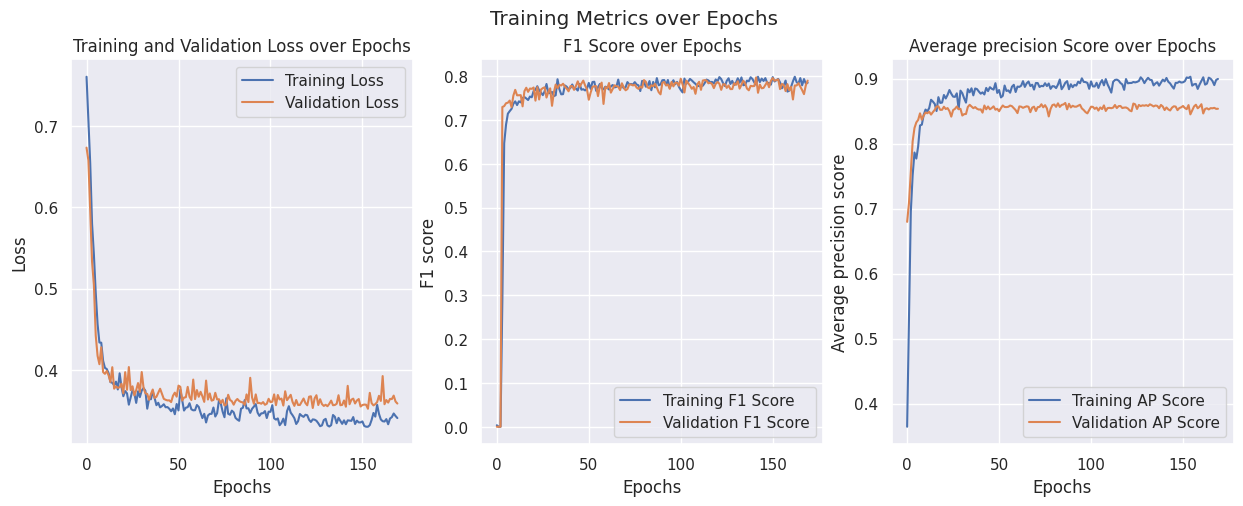

Saving...
Complete the process...


In [42]:
net = Net(in_features = 2048, hidden_nodes_1 =2048,hidden_nodes_2 =1024, hidden_nodes_3=256, drop_out=0.5)
pip = model_pipeline(device = device, seed = 42,
                     save_dir = '.')
pip.fit(
    data_train = train_loader,data_valid = test_loader,epochs =170, show_progress = True,
    model = net,lr=0.0001, weight_decay=0.05, factor=0.9, patience=1)

In [44]:
criterion = torch.nn.BCELoss()
checkpoint = torch.load('./ANN_model.pth')
model  =  Net(in_features = 2048, hidden_nodes_1 =2048,hidden_nodes_2 =1024, hidden_nodes_3=256, drop_out=0.5)

y_pre , y_true = pip.predict(test_loader, model =model, checkpoint=checkpoint,)
print(classification_report(y_true, y_pre))

y_proba, y_true = pip.predict_proba(test_loader, model =model, checkpoint=checkpoint,
                                   criterion=criterion)

print("Average precision score", average_precision_score(y_true ,y_proba))
print("F1 score", f1_score(y_true ,y_pre))
print("Recall score", recall_score(y_true ,y_pre))

              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90       263
         1.0       0.86      0.73      0.79       146

    accuracy                           0.86       409
   macro avg       0.86      0.83      0.84       409
weighted avg       0.86      0.86      0.86       409

Average precision score 0.853623637192412
F1 score 0.7896678966789669
Recall score 0.7328767123287672


In [77]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.491328, F-Score=0.799


In [82]:
y_prob_flat = []
y_pred_new = []
for key, values in enumerate(y_proba):
    y_prob_flat.append(values[0])
    if values[0] < 0.491328:
        y_pred_new.append(0)
    else:
        y_pred_new.append(1)

In [83]:
print(classification_report(y_true, y_pred_new))
print("F1 score", f1_score(y_true ,y_pred_new))
print("Recall score", recall_score(y_true ,y_pred_new))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90       263
         1.0       0.86      0.75      0.80       146

    accuracy                           0.87       409
   macro avg       0.86      0.84      0.85       409
weighted avg       0.87      0.87      0.86       409

F1 score 0.7985347985347986
Recall score 0.7465753424657534


# 5. Comparison

## 5.1. Evaluation

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3,
                            random_state=42)
X = df.drop(['ID','pIC50'],axis = 1)
y = df["pIC50"]
#Split Data train, Data_test, Data_validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                                random_state =42, stratify=y)

In [124]:
from sklearn.svm import SVC
model = SVC(probability=True)

print('Internal Validation - SVC')
scores_f1 = cross_val_score(model, X_train, y_train, scoring = "f1", cv=cv, n_jobs = -1)
scores_ap=cross_val_score(model, X_train, y_train, scoring = "average_precision",
                        cv= cv, n_jobs = -1)
scores_recall=cross_val_score(model, X_train, y_train, scoring = "recall",
                        cv= cv, n_jobs = -1)


print('>%s %.3f ± %.3f (%.3f)' % ('F1-cv:', np.mean(scores_f1), np.std(scores_f1), np.median(scores_f1)))
print('>%s %.3f ± %.3f (%.3f)' % ('AP-cv:', np.mean(scores_ap), np.std(scores_ap), np.median(scores_ap)))
print('>%s %.3f ± %.3f (%.3f)' % ('Recall-cv:', np.mean(scores_recall), np.std(scores_recall), np.median(scores_recall)))

print('External Validation - SVC')
model.fit(X_train, y_train)
print(classification_report(y_test,model.predict(X_test)))
print("Average precision score", average_precision_score(y_test, model.predict_proba(X_test)[:,1]))
print("F1 score", f1_score(y_test, model.predict(X_test)))
print("Recall score", recall_score(y_test, model.predict(X_test)))

record = {"F1_score": scores_f1,
         "AP_score": scores_ap,
         "Recall_score": scores_recall}
df_record = pd.DataFrame(record)
df_record.to_csv("./Data/QSAR/Compare/SVC.csv", index=False)

Internal Validation - SVC
>F1-cv: 0.734 ± 0.047 (0.734)
>AP-cv: 0.858 ± 0.034 (0.849)
>Recall-cv: 0.645 ± 0.062 (0.650)
External Validation - SVC
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       263
           1       0.80      0.75      0.77       146

    accuracy                           0.84       409
   macro avg       0.83      0.82      0.82       409
weighted avg       0.84      0.84      0.84       409

Average precision score 0.8403695047099706
F1 score 0.7715355805243447
Recall score 0.7054794520547946


In [125]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)

print('Internal Validation - Random Forest')
scores_f1 = cross_val_score(model, X_train, y_train, scoring = "f1", cv=cv, n_jobs = -1)
scores_ap=cross_val_score(model, X_train, y_train, scoring = "average_precision",
                        cv= cv, n_jobs = -1)
scores_recall=cross_val_score(model, X_train, y_train, scoring = "recall",
                        cv= cv, n_jobs = -1)


print('>%s %.3f ± %.3f (%.3f)' % ('F1-cv:', np.mean(scores_f1), np.std(scores_f1), np.median(scores_f1)))
print('>%s %.3f ± %.3f (%.3f)' % ('AP-cv:', np.mean(scores_ap), np.std(scores_ap), np.median(scores_ap)))
print('>%s %.3f ± %.3f (%.3f)' % ('Recall-cv:', np.mean(scores_recall), np.std(scores_recall), np.median(scores_recall)))

print('External Validation - Random Forest')
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))
print("Average precision score", average_precision_score(y_test, model.predict_proba(X_test)[:,1]))
print("F1 score", f1_score(y_test, model.predict(X_test)))
print("Recall score", recall_score(y_test, model.predict(X_test)))

record = {"F1_score": scores_f1,
         "AP_score": scores_ap,
         "Recall_score": scores_recall}
df_record = pd.DataFrame(record)
df_record.to_csv("./Data/QSAR/Compare/RF.csv", index=False)

Internal Validation - Random Forest
>F1-cv: 0.740 ± 0.049 (0.742)
>AP-cv: 0.848 ± 0.037 (0.832)
>Recall-cv: 0.678 ± 0.063 (0.675)
External Validation - Random Forest
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       263
           1       0.80      0.75      0.77       146

    accuracy                           0.84       409
   macro avg       0.83      0.82      0.82       409
weighted avg       0.84      0.84      0.84       409

Average precision score 0.8644579562657897
F1 score 0.7703180212014135
Recall score 0.7465753424657534


In [115]:
net = Net(in_features = 2048, hidden_nodes_1 =2048,hidden_nodes_2 =1024, hidden_nodes_3=256, drop_out=0.5)
pip = model_pipeline(device = device, seed = 42,
                     save_dir = '.')

pip.cross_val_score(model = net,epochs=170, X_train=X_train, y_train=y_train, cv=cv)

Fold: 1..  validation f1_score: 0.796..  validation average precision: 0.899.. 
Fold: 2..  validation f1_score: 0.706..  validation average precision: 0.821.. 
Fold: 3..  validation f1_score: 0.733..  validation average precision: 0.835.. 
Fold: 4..  validation f1_score: 0.738..  validation average precision: 0.852.. 
Fold: 5..  validation f1_score: 0.706..  validation average precision: 0.841.. 
Fold: 6..  validation f1_score: 0.800..  validation average precision: 0.894.. 
Fold: 7..  validation f1_score: 0.733..  validation average precision: 0.881.. 
Fold: 8..  validation f1_score: 0.733..  validation average precision: 0.877.. 
Fold: 9..  validation f1_score: 0.760..  validation average precision: 0.849.. 
Fold: 10..  validation f1_score: 0.714..  validation average precision: 0.853.. 
Fold: 11..  validation f1_score: 0.800..  validation average precision: 0.910.. 
Fold: 12..  validation f1_score: 0.729..  validation average precision: 0.909.. 
Fold: 13..  validation f1_score: 0.73

In [134]:
f1_ann =pd.DataFrame(pip.History['F1_record'], columns =['F1_score'])
ap_ann =pd.DataFrame(pip.History['AP_record'], columns =['AP_score'])
df_record_ann = pd.concat([f1_ann, ap_ann], axis=1)
df_record_ann.to_csv("./Data/QSAR/Compare/ANN.csv", index=False)

## 5.2. Statistical test

In [135]:
svc = pd.read_csv("./Data/QSAR/Compare/SVC.csv",)
rf = pd.read_csv("./Data/QSAR/Compare/RF.csv",)
ann = pd.read_csv("./Data/QSAR/Compare/ANN.csv",)

In [165]:
F1_internal =pd.DataFrame({"SVC":svc["F1_score"].values,
                           "ANN":ann["F1_score"].values,
                          "RF":rf["F1_score"].values})

/home/labhhc/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


SVC vs. ANN: Custom statistical test, P_val:1.161e-01
ANN vs. RF: Custom statistical test, P_val:4.174e-01


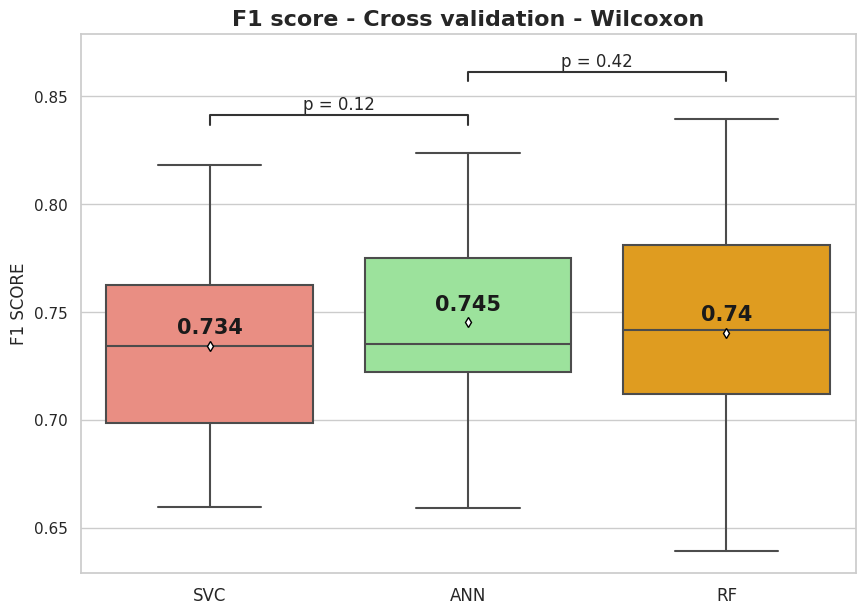

In [166]:
import numpy as np
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = pd.melt(F1_internal.reset_index(), id_vars=['index'], value_vars=F1_internal.columns)
df_melt.columns = ['index', 'Model', 'F1']
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)

stat_results = [wilcoxon(F1_internal['SVC'].astype('float'), F1_internal['ANN'].astype('float'), alternative="two-sided"),
                wilcoxon(F1_internal['RF'].astype('float'), F1_internal['ANN'].astype('float'), alternative="two-sided"),
               ]

pvalues = [result.pvalue for result in stat_results]
plotting_parameters = {
'data':    df_melt,
'x':       'Model',
'y':       'F1',
'palette': subcat_palette[1:]}

pairs = [('SVC', 'ANN'),
          ('RF', 'ANN'),]


sns.set_style("whitegrid")
plt.figure(figsize = (10,7))

my_colors = {'SVC': 'salmon', 
             'RF': 'orange', 
             # 'SS': 'lightgreen',
             # 'GS': 'lightblue',
             'ANN': 'lightgreen'}


ax = sns.boxplot(x='Model', y='F1', data=df_melt, palette=my_colors, showmeans=True ,meanprops={"marker":"d",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"})

mean = round(F1_internal.mean(),3)
data = np.array(mean)   
ser = pd.Series(data, index =F1_internal.columns)

dict_columns = {'Mean':mean,}
df = pd.DataFrame(dict_columns)

vertical_offset = df["Mean"].median()*0.008

for xtick in ax.get_xticks():
    ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick], horizontalalignment='center',color='k',weight='semibold', fontsize = 15)


annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.configure(text_format="simple")
annotator.set_pvalues_and_annotate(pvalues)

ax.set_ylabel('F1 SCORE', fontsize = 12)
ax.set_xlabel(None)
ax.set_xticklabels(labels = F1_internal.columns, fontsize = 12)
ax.set_title("F1 score - Cross validation - Wilcoxon",fontsize = 16, weight ='semibold')
plt.savefig("./Data/QSAR/Compare/f1_compare.png", dpi = 600)
plt.show()

SVC vs. ANN: Custom statistical test, P_val:8.407e-02
ANN vs. RF: Custom statistical test, P_val:1.341e-03


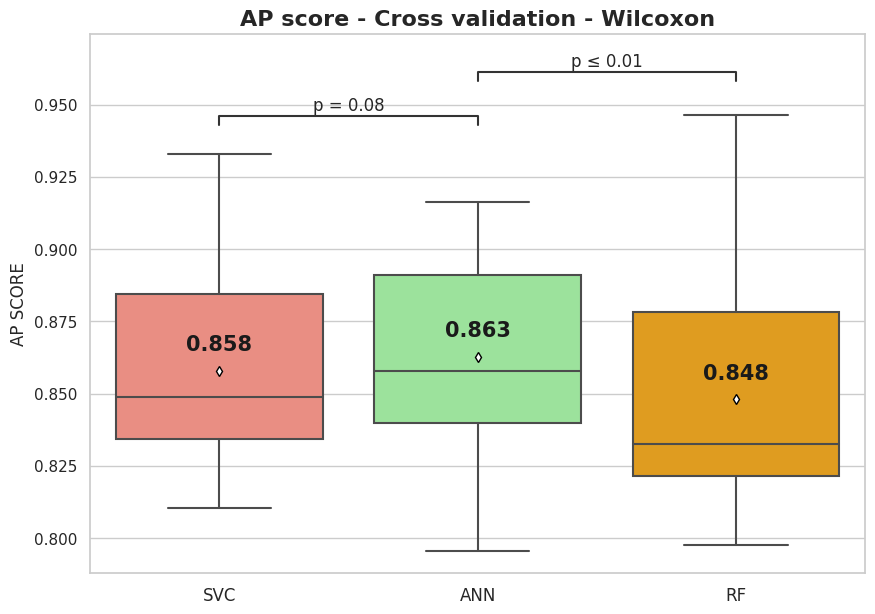

In [167]:
import numpy as np
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt

F1_internal =pd.DataFrame({"SVC":svc["AP_score"].values,
                           "ANN":ann["AP_score"].values,
                          "RF":rf["AP_score"].values})

df_melt = pd.melt(F1_internal.reset_index(), id_vars=['index'], value_vars=F1_internal.columns)
df_melt.columns = ['index', 'Model', 'F1']
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)

stat_results = [wilcoxon(F1_internal['SVC'].astype('float'), F1_internal['ANN'].astype('float'), alternative="two-sided"),
                wilcoxon(F1_internal['RF'].astype('float'), F1_internal['ANN'].astype('float'), alternative="two-sided"),
               ]

pvalues = [result.pvalue for result in stat_results]
plotting_parameters = {
'data':    df_melt,
'x':       'Model',
'y':       'F1',
'palette': subcat_palette[1:]}

pairs = [('SVC', 'ANN'),
          ('RF', 'ANN'),]


sns.set_style("whitegrid")
plt.figure(figsize = (10,7))

my_colors = {'SVC': 'salmon', 
             'RF': 'orange', 
             # 'SS': 'lightgreen',
             # 'GS': 'lightblue',
             'ANN': 'lightgreen'}


ax = sns.boxplot(x='Model', y='F1', data=df_melt, palette=my_colors, showmeans=True ,meanprops={"marker":"d",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"})

mean = round(F1_internal.mean(),3)
data = np.array(mean)   
ser = pd.Series(data, index =F1_internal.columns)

dict_columns = {'Mean':mean,}
df = pd.DataFrame(dict_columns)

vertical_offset = df["Mean"].median()*0.008

for xtick in ax.get_xticks():
    ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick], horizontalalignment='center',color='k',weight='semibold', fontsize = 15)


annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.configure(text_format="simple")
annotator.set_pvalues_and_annotate(pvalues)

ax.set_ylabel('AP SCORE', fontsize = 12)
ax.set_xlabel(None)
ax.set_xticklabels(labels = F1_internal.columns, fontsize = 12)
ax.set_title("AP score - Cross validation - Wilcoxon",fontsize = 16, weight ='semibold')
plt.savefig("./Data/QSAR/Compare/ap_compare.png", dpi = 600)
plt.show()
#plt.savefig("ML_f1_compare_tune.png", dpi = 600)